<a href="https://colab.research.google.com/github/eladses/sudoku-solver/blob/main/sudoku_solver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**in development!! not done**

sudoku solver using openCV, pytesseract and py-sudoku to find solution of sudoku from image

---

**How To Use**

1. upload image
2. run imports
3. run functions
4. run algorethms

---

**How It Works**

1. extraction board
  1. finding biggest square
  2.
2. filtering cells
  1.
  2.


# Imports

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install py-sudoku
!pip install opencv-python

In [ ]:
import numpy as np
import cv2

from imutils import contours
from google.colab.patches import cv2_imshow

from sudoku import Sudoku

from PIL import Image
import requests

import pytesseract
# pytesseract.pytesseract.tesseract_cmd = (
#     r'/usr/bin/tesseract'
# )

from tensorflow import keras
import matplotlib.pyplot as plt

# Upload

In [ ]:
sudoku_url = 'https://i.redd.it/y4f37ifec7aa1.jpg'
img = np.array(Image.open(requests.get(sudoku_url, stream=True).raw))[:, :, ::-1].copy()

In [ ]:
cv2_imshow(img)

# computer vision functions

In [ ]:
def get_board(img):
    """corpes the board from image

    Args:
      img (cv2 image format) - the image of the sudocu

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    ret,thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    if len(contours) != 0:

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        epsilon = 0.1 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        # draw the biggest contour (c) in green


    def order_points(pts):
        '''Rearrange coordinates to order:
          top-left, top-right, bottom-right, bottom-left'''
        rect = np.zeros((4, 2), dtype='float32')
        pts = np.array(pts)
        s = pts.sum(axis=1)
        # Top-left point will have the smallest sum.
        rect[0] = pts[np.argmin(s)]
        # Bottom-right point will have the largest sum.
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        # Top-right point will have the smallest difference.
        rect[3] = pts[np.argmin(diff)]
        # Bottom-left will have the largest difference.
        rect[1] = pts[np.argmax(diff)]
        # return the ordered coordinates
        return rect.astype('int').tolist()


    pt_A,pt_B,pt_C,pt_D=order_points([corners[0][0],corners[1][0],corners[2][0],corners[3][0]])

    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])

    # Getting the homography.
    M = cv2.getPerspectiveTransform(input_pts,output_pts)

    return cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

In [125]:
def remove_small_contours(img,small_area=1000):
  """this founction remove small countours from the image. used to remove the numbers

  Args:
    img (cv2 image format)

  Returns:
    img (cv2 image format)
  """

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cnts, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
      area = cv2.contourArea(c)
      if area < small_area:
        x, y, w, h = cv2.boundingRect(c)
        cv2.drawContours(mask, [c], 0, (255), -1)

  return img-mask


def get_cells(board_img,board_lines_mask):
    """corpes the cells from the board

    Args:
      board_img (cv2 image format) - board
      board_lines_mask (cv2 image format) - board lines

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """

    invert = 255 - board_lines_mask
    cv2_imshow(invert)
    cnts,_ = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

    newBoard = board.copy()
    rectangles=[]
    for c in cnts:
      if(cv2.contourArea(c)<0**2): continue
      x,y,w,h = cv2.boundingRect(c)
      if(w<board_img.shape[0]/18 or h<board_img.shape[1]/18): continue
      # print(cv2.boundingRect(c))
      rectangles.append(cv2.boundingRect(c))
    print(len(rectangles))
    # for rectangle in rectangles:
    #   cv2_imshow(board[rectangle[0]:(rectangle[0] + rectangle[2]),rectangle[1]:(rectangle[1]+ rectangle[3])])

    a,b,_=board_img.shape

    rectangles = sorted(rectangles, key=lambda x: int(x[0]/a*9)/100+int(x[1]/b*9), reverse=False)
    i=0
    for c in rectangles:
      x,y,w,h=c
      cv2.rectangle(newBoard, (x, y), (x + w, y + h), (255,0,0), 1)
      cv2.putText(newBoard, str(i), (x,y+h),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
      i+=1

    cv2_imshow(newBoard)

    return rectangles




# sudoku functions

In [ ]:
puzzle = Sudoku(3).difficulty(0.5)
def load_sudoku(board):
  return Sudoku(3, 3, board=board)
def solve_sudoku(sudoku):
  return puzzle.solve()

In [ ]:
game = load_sudoku(puzzle.board)
print(game.board)
print(solve_sudoku(game).board)

# Program

In [ ]:
# crop board
cv2_imshow(img)
board=get_board(img)

cv2_imshow(board)

In [ ]:
# get board lines
board_gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
_,board_thresh = cv2.threshold(board_gray,150,255,cv2.THRESH_BINARY_INV)
board_clean = remove_small_contours(board_thresh,board_thresh.shape[0]*board_thresh.shape[1]/260)

cv2_imshow(board_clean)

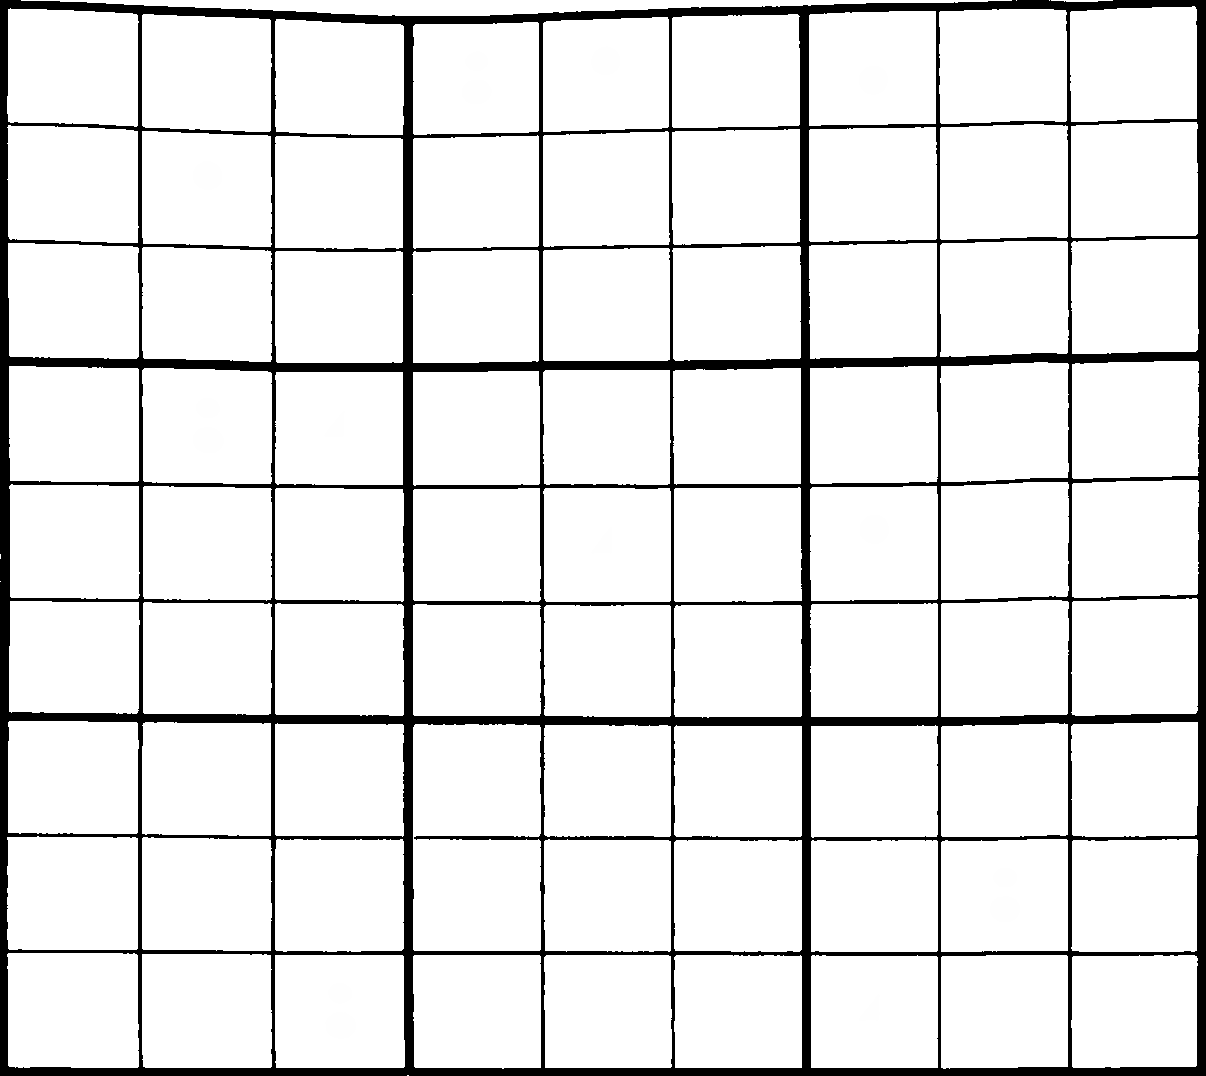

80


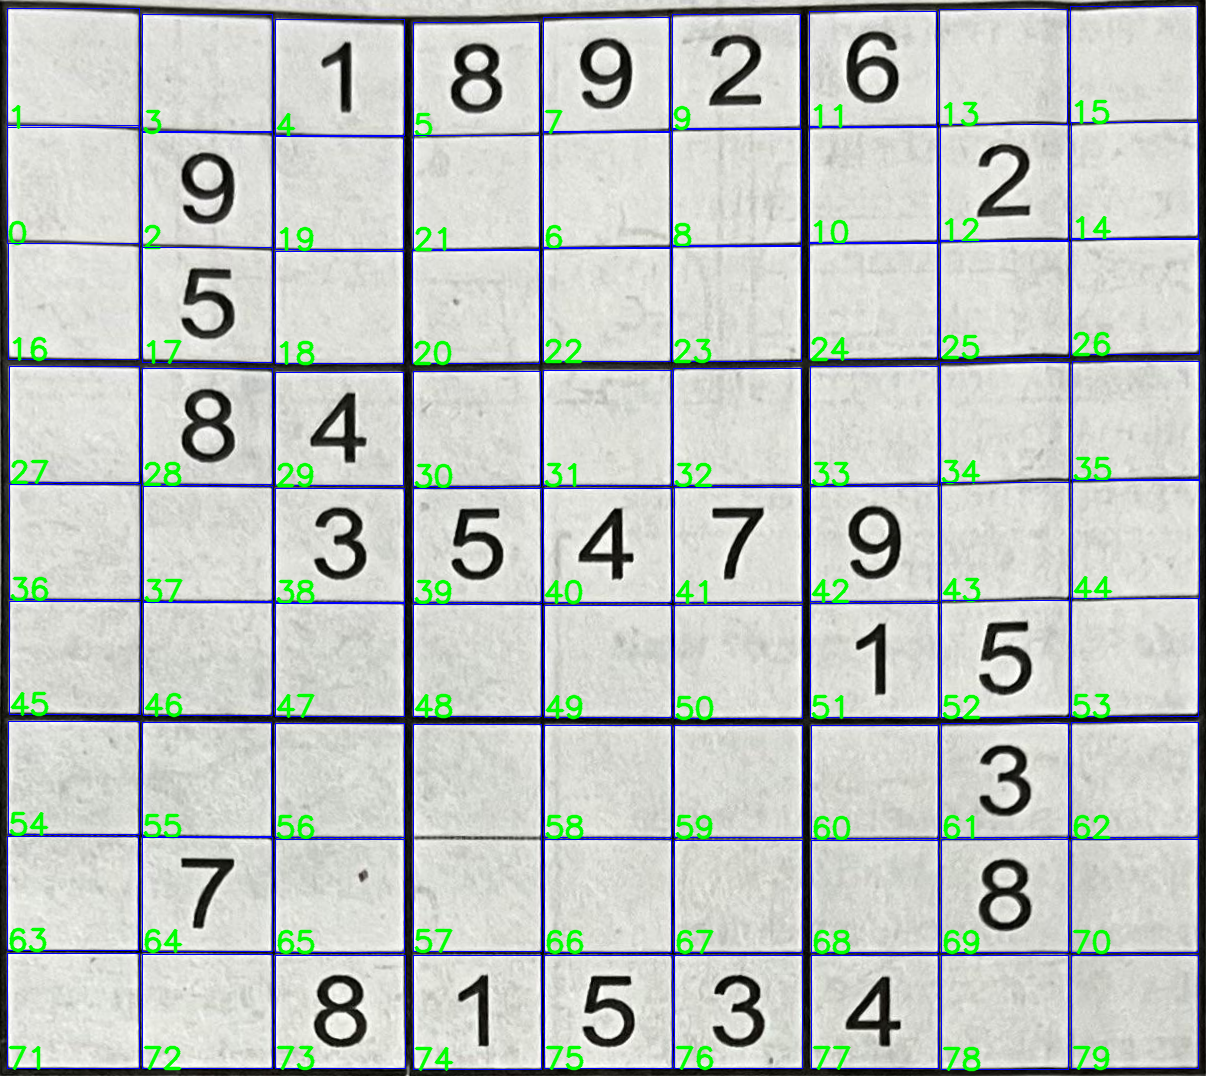

[(7, 125, 132, 118), (7, 8, 132, 119), (142, 131, 130, 116), (142, 14, 130, 118), (275, 19, 129, 116), (413, 22, 126, 113), (543, 131, 127, 116), (543, 17, 126, 115), (672, 129, 129, 116), (672, 14, 128, 114), (809, 127, 128, 115), (809, 11, 127, 115), (940, 124, 128, 116), (939, 9, 128, 115), (1071, 122, 127, 116), (1070, 6, 127, 116), (8, 243, 131, 116), (142, 247, 130, 115), (275, 251, 128, 112), (275, 136, 128, 113), (412, 250, 127, 113), (413, 135, 126, 114), (543, 248, 127, 113), (672, 246, 129, 115), (809, 243, 128, 116), (940, 241, 129, 116), (1071, 239, 128, 115), (9, 366, 130, 116), (142, 368, 130, 116), (275, 372, 128, 113), (413, 371, 127, 115), (543, 370, 128, 115), (673, 368, 128, 117), (810, 366, 128, 118), (940, 362, 129, 120), (1072, 361, 127, 118), (9, 484, 131, 115), (143, 486, 129, 115), (275, 488, 129, 114), (413, 488, 128, 114), (543, 488, 128, 114), (674, 487, 128, 115), (810, 486, 128, 115), (941, 482, 128, 118), (1072, 480, 127, 118), (9, 601, 131, 113), (143, 

In [126]:
rectangels=get_cells(board,board_clean)

print(rectangels)

cells=[board[y:y+ h,x:x + w] for (x,y,w,h) in rectangels]

In [ ]:
cv2_imshow()